In [1]:
import numpy as np
import pyNNGP
import matplotlib.pyplot as plt
import ipywidgets as widgets

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
from IPython.display import Image
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

%matplotlib inline

# Bayesian Sparse Estimation of Gaussian Process Regression via the Nearest Neighbor Gaussian Process

*MADSTARE LDRD machine learning tutorials*

In this tutorial we discuss estimating Gaussian Process (GP) Regression using the Nearest Neighbor Gaussian Process (NNGP) due to Datta, Banerjee, Finley, and Gelfand.

## Gaussian Process Regression

See Rasmussen and Williams, Chapter 2 for a full description of GP regression. 

At a high level, scalar GPs on a $d$-dimensional input space $\mathcal{D}$ of dimension $d$ feature 

* A mean function $m : \mathcal{D} \rightarrow \mathbb{R}$
    * We will assume that $m$ is the zero function throughout
* A kernel or covariance function $k : \mathcal{D} \times \mathcal{D} \rightarrow \mathbb{R}$. 

These functions then describe a distribution over functions,
$$
f(\cdot) \sim \mathcal{GP}(m(\cdot), k(\cdot, \cdot)).
$$

For sets $X, Y \subseteq \mathcal{D}$,  $|X| = n_X$, $|Y| = n_Y$ let $K_{X,Y} \in \mathbb{R}^{n_X \times n_Y}$ be the cross-covariance of $X$ and $Y$ by application of covariance function $k$.
* In particular, $K_{X, X}$ is the covariance of $X$ with respect to $k$.

We will assume a set of $n$ *training* observations $X \subseteq \mathcal{D}$.

We can sample an $n$-vector $\mathbf{y}$ of all evaluations of a function $f(\cdot)$ drawn from $\mathcal{GP}(\mathbf{0}, k(\cdot, \cdot))$ evaluated at all points $X$ in the presence of homoscedastic noise $\sigma_n^2$ via

$$
\mathbf{y} \sim \mathcal{N} \left( \mathbf{0}, K_{X, X} + \sigma_n^2 \mathbf{I} \right)
$$

We can compute the marginal loglikelihood of this sampled vector via

$$
\log p(\mathbf{y} \mid X) = 
    -\frac{1}{2} \mathbf{y}^\intercal \left( K_{X, X} + \sigma_n^2 \mathbf{I} \right)^{-1} \mathbf{y}
    -\frac{1}{2} \log \left| K_{X, X} + \sigma_n^2 \mathbf{I} \right| 
    -\frac{n}{2} \log 2\pi.
$$

Let $X_* \subseteq \mathcal{D}$ be a set of $n_*$ unknown points.

We can predict function values at $X_*$ by sampling from the posterior distribtuion conditioned upon $X$

$$
\mathbf{y}_* \mid X_*, X, \mathbf{y} \sim \mathcal{N} 
    \left( 
        K_{X_*, X} \left[ K_{X,X} + \sigma_n^2 \mathbf{I} \right]^{-1} \mathbf{y},
        K_{X_*, X_*} - K_{X_*, X} \left[ K_{X,X} + \sigma_n^2 \mathbf{I} \right]^{-1} K_{X, X_*} 
    \right)
$$

Some report the mean (also mode) of this distribution as the maximum a posteriori (MAP) estimate rather than sampling.

## Gaussian Process Regression in Practice

In general, $k$ has hyperparameters which must themselves be optimized, resulting in the need to perform posterior sampling/estimation many times.

* We will ignore the details of hyperparameter optimization in this lecture

In practical terms, GP regression features many nice features

* Fully Bayesian inference of posterior distribution via MCMC sampling
* Error bars!
* Parallelizable and GPU-acceleratable dense linear algebra

However, there is a significant drawback:

* Cholesky factorization requires $O(n^3)$ operations per iteration!
    * Inference, loglikelihood expensive to compute!
* Many elements of $K_{X,X}$ small in practice, costing extra work for small benefit

# NNGP and Sparse Estimation

The NNGP attempts to address computational overhead by sparsifying the covariance matrices. 

* There are many different approaches to estimate $\mathcal{GP}(\mathbf{0}, k(\cdot, \cdot))$ using low-rank and sparsification methods.
* See the 2017 survey by Heaton et al. for more details

Why NNGP?
* Model allows fully-Bayesian sampling and inference
* Competitive with other models from spatial statistics 
* Bilinear number of kernel evaluations per iteration
    * Neural network kernel evaluations are very expensive
    * More on this later...

## The idea

* Factorize joint distribution of observations
* Permit variables to condition on at most $m$ neighbors
* Decide upon neighbors based upon distance in $\mathcal{D}$
    * More on this later...

<center><img src='imgs/full_graph.png'></center>
$$
p(\mathbf{y}_1)
p(\mathbf{y}_2 \mid \mathbf{y}_1)
p(\mathbf{y}_3 \mid \mathbf{y}_2, \mathbf{y}_1)
p(\mathbf{y}_4 \mid \mathbf{y}_3, \mathbf{y}_2, \mathbf{y}_1)
p(\mathbf{y}_5 \mid \mathbf{y}_4,\mathbf{y}_3, \mathbf{y}_2, \mathbf{y}_1)
p(\mathbf{y}_6 \mid \mathbf{y}_5, \mathbf{y}_4,\mathbf{y}_3, \mathbf{y}_2, \mathbf{y}_1)
p(\mathbf{y}_7 \mid \mathbf{y}_6, \mathbf{y}_5, \mathbf{y}_4,\mathbf{y}_3, \mathbf{y}_2, \mathbf{y}_1)
$$ 

<center><img src='imgs/sparse_graph.png'></center>
$$
p(\mathbf{y}_1)
p(\mathbf{y}_2 \mid \mathbf{y}_1)
p(\mathbf{y}_3 \mid \mathbf{y}_2, \mathbf{y}_1)
p(\mathbf{y}_4 \mid \mathbf{y}_3, \mathbf{y}_2)
p(\mathbf{y}_5 \mid \mathbf{y}_4, \mathbf{y}_3)
p(\mathbf{y}_6 \mid \mathbf{y}_5, \mathbf{y}_4)
p(\mathbf{y}_7 \mid \mathbf{y}_6, \mathbf{y}_1)
$$ 

## The Math

Introduce sparsity by modeling the diagonalized Cholesky factorization of $K = K_{X, X}$:

$$
K = (\mathbf{I} - A)^{-1} D (\mathbf{I} - A)^{-\intercal}
$$

* $D$ triangular
* $A$ lower diagonal so that $L^{-1} = \mathbf{I} - A$
    * where $L$ is such that $\mathrm{chol}(K) = LDL^\intercal$

Sparsify $A$ so that each row contains at most $m$ nonzero elements

Let $i \in [n]$ be an index in $X$.
* $N(i)$ is the set of m nearest neighbor indices
* For a matrix $M$, index $j$ and index set $J$, $M_{j, J} = \{M_{j, k} \mid k \in J \}$ 

Then the rows of $A$ are defined by
$$
A_{i, N(i)} = K_{i, N(i)} K_{N(i), N(i)}^{-1}
$$

and the diagonal elements of $D$ are defined by
$$
D_{i, i} = K_{i, i} - K_{i, N(i)} K_{N(i), N(i)}^{-1} K_{N(i), i}
$$

Hence, 
$$
\tilde{K} = (\mathbf{I} - A)^{-1} D (\mathbf{I} - A)^{-\intercal}
$$
is a covariance matrix whose inverse is sparse:
$$
\tilde{K}^{-1} = (\mathbf{I} - A)^\intercal D (\mathbf{I} - A)
$$

Benefits:

* $O(nm^2)$ solve cost
* $O(nm)$ quadratic form cost
$$
\mathbf{u}^{\intercal} \tilde{K}^{-1} \mathbf{v}  = 
    \sum^n_{i = 1} 
        \frac{
            \left( \mathbf{u}_i - A_{i, N(i)} \mathbf{u}_{N(i)} \right )
            \left( \mathbf{v}_i - A_{i, N(i)} \mathbf{v}_{N(i)} \right )
        }{D_{i,i}}
$$
* $O(n)$ determinant cost 
$$
|\tilde{K}| = \prod^n_{i=1} D_{i, i}
$$

# 2d Example problem
We consider a function on two inputs given by 
$$
f(x, y) = \sin(5xy) + \sin \left (5 \frac{x}{y} \right).
$$
* We uniformly sample 600 pairs of coordinates on $[0, 1]^2$, assuming that they are perturbed by $\mathcal{N} \left(0, \frac{1}{4} \right)$ homoscedastic noise.
* We then attempt to predict 3000 pairs of coordinates, and plot the results.

In [2]:
n = 600
nstar = 3000
np.random.seed(5)
coords = np.random.uniform(0, 1, size=(n, 2))
s = np.argsort(coords[:,0])
coords = coords[s]

def f(x, y):
    return np.sin(5 * x * y) + np.sin(5 * x / y)

w = f(coords[:, 0], coords[:, 1])
eps = 0.25
noise = np.random.normal(0, eps, size=n)
y = w + noise

# coordinates to interpolate
newcoords = np.random.uniform(0, 1, size=(nstar, 2))
s = np.argsort(newcoords[:,0])
newcoords = newcoords[s]

wstar = f(newcoords[:, 0], newcoords[:, 1])
noisestar = np.random.normal(0, 0.25, size=nstar)
ystar = wstar + noisestar

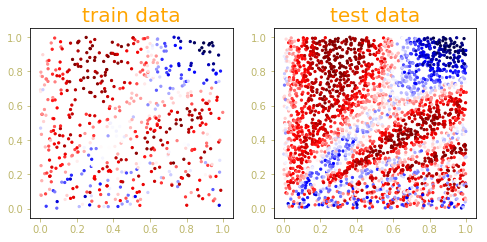

In [3]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3.5))
for ax in axes:
    ax.tick_params(colors="darkkhaki")
i0 = axes[0].scatter(
    coords[:,0], coords[:,1],
    c=y, s=5,
    vmin=-2, vmax=2, cmap='seismic'
)
# plt.colorbar(i0, axes[0])
axes[0].set_title("train data", fontsize=20, color="orange")
i1 = axes[1].scatter(
    newcoords[:,0], newcoords[:,1],
    c=ystar, s=5,
    vmin=-2, vmax=2, cmap='seismic'
)    
# plt.colorbar(i1, axes[1])
axes[1].set_title("test data", fontsize=20, color="orange")
plt.show()

We train the hyperparameters an NNGP with $m=6$ using the squared exponential kernel.

We consider 4 approaches:

* \[GPR\] Conventional GPR, implemented using scikit-learn

* \[DenseMAP\] MAP estimator of dense GPR using NNGP-trained hyperparameters

* \[SparseMAP\] MAP estimator of sparse GPR using sparse NNGP quadratic forms

* \[SampleMean\] Mean of 40 samples from posterior MCMC

## GPR

We implement Gaussian Process regression naively using the sklearn implementation.

In [4]:
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GPR(kernel=kernel, alpha=eps ** 2, n_restarts_optimizer=9)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(coords, y)
# Make the prediction on the meshed x-axis (ask for MSE as well)
wstar_gp, sigma = gp.predict(newcoords, return_std=True)

## NNGP Fitting

We fit an NNGP model using our own implementation.

In [5]:
m = 6

covModel = pyNNGP.SqExp(
    sigmaSq=0.5, 
    phi=5.0, phiUnifa=1.0, phiUnifb=50.0, phiTuning=1.0, 
    sigmaSqIGa=0.04, sigmaSqIGb=0.04
)

noiseModel = pyNNGP.ConstHomogeneousNoiseModel(0.01)

distFunc = pyNNGP.Euclidean()

compFunc = pyNNGP.Lesser()

nngp = pyNNGP.SeqNNGP(
    y, coords,
    nNeighbors=m,
    covModel=covModel,
    distFunc=distFunc,
    compFunc=compFunc,
    noiseModel=noiseModel
)

burn_in = 100
nngp.sample(burn_in)

n_samples = 20
w_samples = []
for i in range(n_samples):
#     print("Iteration {}".format(i))
    nngp.sample(10)
    w_samples.append(np.copy(nngp.w))
w_samples = np.array(w_samples)
w_sample = np.mean(w_samples, axis=0)

In [6]:
@interact(i=widgets.IntSlider(min=0, max=len(w_samples)-1, value=0))
def f(i):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))
    for ax in axes:
        ax.tick_params(colors="darkkhaki")
    i0 = axes[0].scatter(
        coords[:,0], coords[:,1], 
        c=w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i0, ax=axes[0])
    axes[0].set_title("train data", fontsize=20, color="orange")
    i1 = axes[1].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i], s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i1, ax=axes[1])
    axes[1].set_title("Estimates", fontsize=20, color="orange")
    i2 = axes[2].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i]-w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )
    plt.colorbar(i2, ax=axes[2])
    axes[2].set_title("Residual", fontsize=20, color="orange")
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…

### DenseMAP

We use our trained hyperparameters to construct dense matrices to perform GPR.

In [15]:
distMat = np.array([[np.linalg.norm(coords[x, :] - coords[y, :])
                     for x in range(n)] for y in range(n)])
covMat = np.array([[nngp.covModel.cov(distMat[x, y]) 
                    for x in range(n)] for y in range(n)]) + 0.5 * np.eye(n)
np.fill_diagonal(covMat, 1.0)
# invCovMat = np.linalg.inv(covMat)
crossdist = np.array([[np.linalg.norm(coords[y, :] - newcoords[x,:]) 
                       for y in range(n)] for x in range(nstar)])
crosscov = np.array([[nngp.covModel.cov(crossdist[x, y]) 
                      for y in range(n)] for x in range(nstar)])

wstar_dense = np.dot(crosscov, np.linalg.solve(covMat + 0.25 * np.eye(n), y))

### SparseMAP
We use our trained NNGP to produce map estimates by way of quadratic forms for a new observation $x_*$ via
$$
y_* = x_*^\intercal \tilde{K}^{-1} \mathbf{y}
$$

In [8]:
wstar_qf = [nngp.quadratic_form(crosscov[i, :], y) for i in range(nstar)]

### SampleMean

We produce 40 posterior MCMC samples for each point to be interpolated and report their mean. 

The MCMC in question holds the kernel hyperparameters constant.

In [9]:
wstar_sample = nngp.predict(newcoords.T, 40, 10)
wstar_sample = wstar_sample.reshape((nstar))

# Interpolation Results

We plot the results of interpolation for each of the considered approaches. 

For each approach we show the heat maps of the targets, interpolated results, and residuals, and report the histogram of residuals.

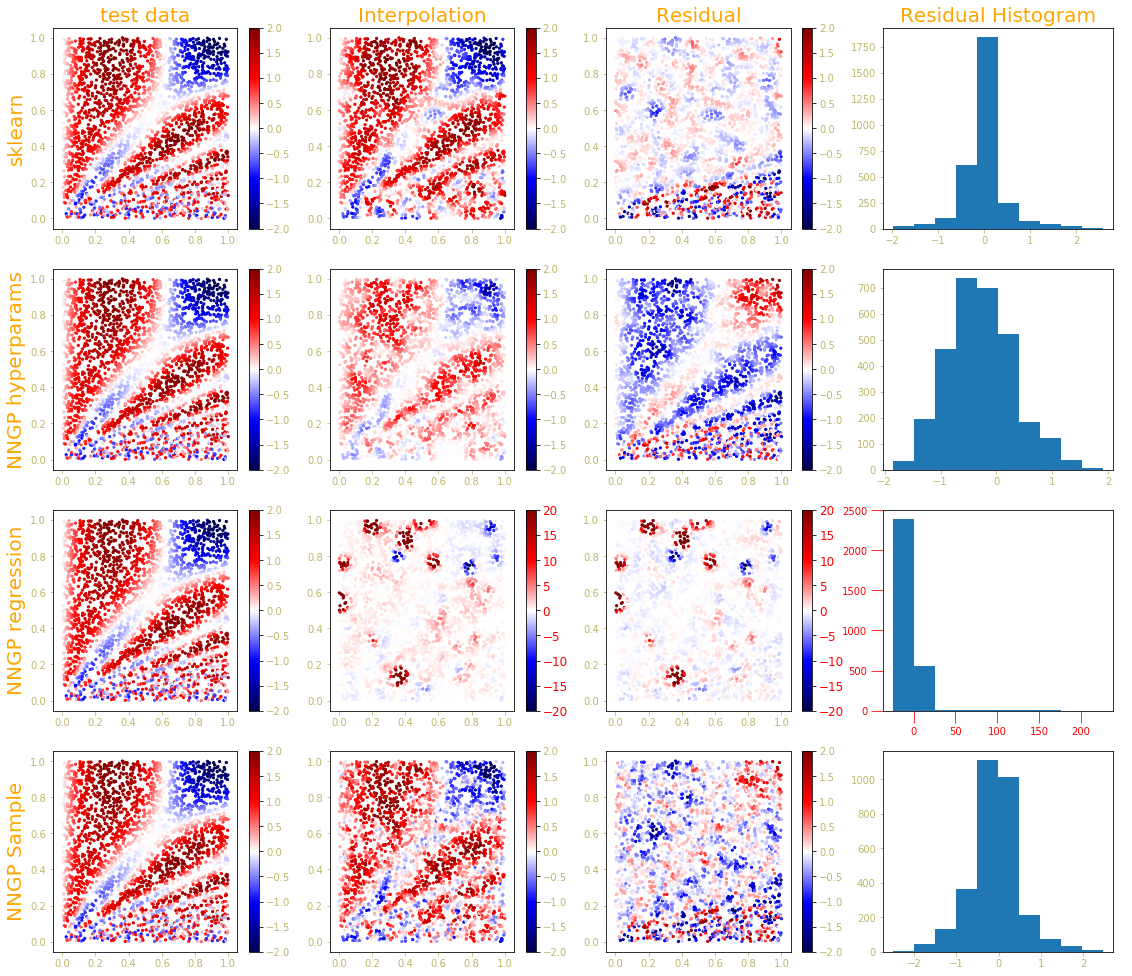

In [17]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(19, 17))
for axar in axes:
    for ax in axar:
        ax.tick_params(colors="darkkhaki")
"""
Full sklearn GPR
"""
i00 = axes[0,0].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i00, ax=axes[0,0]).ax.axes, "yticklabels"), color="darkkhaki")
axes[0,0].set_title("test data", fontsize=20, color="orange")
axes[0,0].set_ylabel("sklearn", fontsize=20, color="orange")
i01 = axes[0,1].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_gp, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i01, ax=axes[0,1]).ax.axes, "yticklabels"), color="darkkhaki")
axes[0,1].set_title("Interpolation", fontsize=20, color="orange")
i02 = axes[0,2].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_gp-wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i02, ax=axes[0,2]).ax.axes, "yticklabels"), color="darkkhaki")
axes[0,2].set_title("Residual", fontsize=20, color="orange")
i03 = axes[0,3].hist(wstar_gp - wstar)
axes[0,3].set_title("Residual Histogram", fontsize=20, color="orange")
"""
Full GPR using NNGP trained hyperparameters
"""
i10 = axes[1,0].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i10, ax=axes[1,0]).ax.axes, "yticklabels"), color="darkkhaki")
axes[1,0].set_ylabel("NNGP hyperparams", fontsize=20, color="orange")
i11 = axes[1,1].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_dense, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i11, ax=axes[1,1]).ax.axes, "yticklabels"), color="darkkhaki")
i12 = axes[1,2].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_dense-wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i12, ax=axes[1,2]).ax.axes, "yticklabels"), color="darkkhaki")
i13 = axes[1,3].hist(wstar_dense - wstar)
"""
Sparse GPR using NNGP trained hyperparameters
"""
i20 = axes[2,0].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i20, ax=axes[2,0]).ax.axes, "yticklabels"), color="darkkhaki")
axes[2,0].set_ylabel("NNGP regression", fontsize=20, color="orange")
i21 = axes[2,1].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_qf, s=5, vmin=-20, vmax=20, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i21, ax=axes[2,1]).ax.axes, "yticklabels"), color="red", size=12)
i22 = axes[2,2].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_qf-wstar, s=5, vmin=-20, vmax=20, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i22, ax=axes[2,2]).ax.axes, "yticklabels"), color="red", size=12)
# truncated_buckets = np.array([wstar_qf[i] - wstar[i] for i in range(nstar) if np.abs(wstar_qf[i] - wstar[i]) < 2])
# i23 = axes[2,3].hist(truncated_buckets)
i23 = axes[2,3].hist(wstar_qf - wstar)
axes[2,3].tick_params(colors="red", size=12)
"""
Sampled GPR using NNGP trained hyperparameters
"""
i30 = axes[3,0].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i30, ax=axes[3,0]).ax.axes, "yticklabels"), color="darkkhaki")
axes[3,0].set_ylabel("NNGP Sample", fontsize=20, color="orange")
i31 = axes[3,1].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_sample, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i31, ax=axes[3,1]).ax.axes, "yticklabels"), color="darkkhaki")
i32 = axes[3,2].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_sample-wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i32, ax=axes[3,2]).ax.axes, "yticklabels"), color="darkkhaki")
i33 = axes[3,3].hist(wstar_sample - wstar)
plt.show()

# Scaling Results

We repeat this same analysis for increasing sizes of $n$, holding the number of interpolated points $n_*$ constant and fixing $m = \log n$

In [13]:
# def make_instance(eps):
#     coords = np.random.uniform(0, 1, size=(n, 2))
#     s = np.argsort(coords[:,0])
#     coords = coords[s]

#     def f(x, y):
#         return np.sin(5 * x * y) + np.sin(5 * x / y)

#     w = f(coords[:, 0], coords[:, 1])
#     noise = np.random.normal(0, eps, size=n)
#     y = w + noise

#     # coordinates to interpolate
#     newcoords = np.random.uniform(0, 1, size=(nstar, 2))
#     s = np.argsort(newcoords[:,0])
#     newcoords = newcoords[s]
#     return y, coords, newcoords


# def naive_GPR(y, coords, newcoords, eps):
#     kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#     gp = GPR(kernel=kernel, alpha=eps ** 2, n_restarts_optimizer=9)
#     # Fit to data using Maximum Likelihood Estimation of the parameters
#     gp.fit(coords, y)
#     # Make the prediction on the meshed x-axis (ask for MSE as well)
#     wstar_gp, sigma = gp.predict(newcoords, return_std=True)
#     return wstar_gp
    
# def make_nngp(y, coords, m, eps):
#     covModel = pyNNGP.SqExp(
#         sigmaSq=0.5, 
#         phi=5.0, phiUnifa=1.0, phiUnifb=50.0, phiTuning=1.0, 
#         sigmaSqIGa=0.04, sigmaSqIGb=0.04
#     )

#     noiseModel = pyNNGP.ConstHomogeneousNoiseModel(0.01)

#     distFunc = pyNNGP.Euclidean()

#     compFunc = pyNNGP.Lesser()

#     nngp = pyNNGP.SeqNNGP(
#         y, coords,
#         nNeighbors=m,
#         covModel=covModel,
#         distFunc=distFunc,
#         compFunc=compFunc,
#         noiseModel=noiseModel
#     )
    
#     burn_in = 100
#     nngp.sample(burn_in)

#     n_samples = 20
#     w_samples = []
#     for i in range(n_samples):
#     #     print("Iteration {}".format(i))
#         nngp.sample(10)
    
#     return nngp

# def dense_GPR(y, coords, newcoords, nstar, nngp):
#     distMat = np.array([[np.linalg.norm(coords[x, :] - coords[y, :])
#                          for x in range(n)] for y in range(n)])
#     covMat = np.array([[nngp.covModel.cov(distMat[x, y]) 
#                         for x in range(n)] for y in range(n)]) + 0.5 * np.eye(n)
#     np.fill_diagonal(covMat, 1.0)
#     crossdist = np.array([[np.linalg.norm(coords[y, :] - newcoords[x,:]) 
#                            for y in range(n)] for x in range(nstar)])
#     crosscov = np.array([[nngp.covModel.cov(crossdist[x, y]) 
#                           for y in range(n)] for x in range(nstar)])

#     wstar_dense = np.dot(crosscov, np.linalg.solve(covMat + 0.01 * np.eye(n), y))
#     return wstar_dense

# def sparse_GPR(y, coords, newcoords, nstar, nngp):
#     crossdist = np.array([[np.linalg.norm(coords[y, :] - newcoords[x,:]) 
#                            for y in range(n)] for x in range(nstar)])
#     crosscov = np.array([[nngp.covModel.cov(crossdist[x, y]) 
#                           for y in range(n)] for x in range(nstar)])
#     wstar_qf = np.array([nngp.quadratic_form(crosscov[i, :], y) for i in range(nstar)])
#     return wstar_qf

# def sample_mean(newcoords, nstar, nngp):
#     wstar_sample = nngp.predict(newcoords.T, 40, 10)
#     wstar_sample = wstar_sample.reshape((nstar))
#     return wstar_sample

In [14]:
# tnaive = %timeit -o -r 1 -n 1 naive_GPR(y, coords, newcoords, eps)
# tfit = %timeit -o -r 1 -n 1 make_nngp(y, coords, newcoords, eps)
# tdense = %timeit -o -r 1 -n 1 dense_GPR(y, coords, newcoords, eps)
# tsparse = %timeit -o -r 1 -n 1 sparse_GPR(y, coords, newcoords, eps)
# tsample = %timeit -o -r 1 -n 1 sample_mean(y, coords, newcoords, eps)